In [1]:
import math
from copy import deepcopy
from typing import Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
from itertools import repeat
import collections.abc

Prequisite classes

In [2]:
class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, bias=True, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        bias = to_2tuple(bias)
        drop_probs = to_2tuple(drop)

        self.fc1 = nn.Linear(in_features, hidden_features, bias=bias[0])
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop_probs[0])
        self.fc2 = nn.Linear(hidden_features, out_features, bias=bias[1])
        self.drop2 = nn.Dropout(drop_probs[1])

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

def _ntuple(n):
    def parse(x):
        if isinstance(x, collections.abc.Iterable) and not isinstance(x, str):
            return x
        return tuple(repeat(x, n))
    return parse

to_2tuple = _ntuple(2)

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob: float = 0., scale_by_keep: bool = True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)

    def extra_repr(self):
        return f'drop_prob={round(self.drop_prob,3):0.3f}'

 # **Paper: [Twins Transformer](http://arxiv.org/abs/2104.13840)**

In [3]:
Size_ = Tuple[int, int]

class LocallyGroupedAttn(nn.Module):
    """ LSA: self attention within a group
    """
    def __init__(self, dim, num_heads=8, attn_drop=0., proj_drop=0., ws=1):
        assert ws != 1
        super(LocallyGroupedAttn, self).__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.ws = ws

    def forward(self, x, size: Size_):
        # There are two implementations for this function, zero padding or mask. We don't observe obvious difference for
        # both. You can choose any one, we recommend forward_padding because it's neat. However,
        # the masking implementation is more reasonable and accurate.
        B, N, C = x.shape
        # x: B,H*W,C
        H, W = size
        x = x.view(B, H, W, C) # x: B, H ,W , C
        pad_l = pad_t = 0
        pad_r = (self.ws - W % self.ws) % self.ws
        pad_b = (self.ws - H % self.ws) % self.ws
        x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b)) # padds last 3 dimensions, channel by 0,0, height by pad_l, pad_r, width by pad_t, pad_b
        # Hp = H + pad_r, Wp = W + pad_b 
        _, Hp, Wp, _ = x.shape
        _h, _w = Hp // self.ws, Wp // self.ws #_h and _w will be the number of the padded smaller windows horizontally and vertically on 2D
        x = x.reshape(B, _h, self.ws, _w, self.ws, C).transpose(2, 3) #B,_h,_w,patches in vertical windows, patches in horizontal windows, channels for each patch
        #qkv: each of q k v, B, _h*_w, heads, num_windows,  dim_head
        qkv = self.qkv(x).reshape(
            B, _h * _w, self.ws * self.ws, 3, self.num_heads, C // self.num_heads).permute(3, 0, 1, 4, 2, 5)
        q, k, v = qkv[0], qkv[1], qkv[2] # q,k,v: B, _h*_w, heads, num_patches, dim_head
        attn = (q @ k.transpose(-2, -1)) * self.scale # attn: B, _h * _w, heads, num_patches,num_patches -- dot product between each patch in each window
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        attn = (attn @ v).transpose(2, 3).reshape(B, _h, _w, self.ws, self.ws, C) # Attention is done, we get attn: B, _h, _w,  num_patches , num_patches, channels
        x = attn.transpose(2, 3).reshape(B, _h * self.ws, _w * self.ws, C) # getting back the whole image again with x: B, padded height, padded width, channels
        if pad_r > 0 or pad_b > 0: # If padded somehow, remove the elements in the places of paddings
            x = x[:, :H, :W, :].contiguous() # x: B, H, W, C
        x = x.reshape(B, N, C) # x: B, H*W, C
        x = self.proj(x) #projection of the x tensor to dim channels I DID NOT NDERSTAND WHY EXACTLY
        x = self.proj_drop(x)
        return x
    
class GlobalSubSampleAttn(nn.Module):
    """ GSA: using a  key to summarize the information for a group to be efficient.
    """

    def __init__(self, dim, num_heads=8, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=True)
        self.kv = nn.Linear(dim, dim * 2, bias=True)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)
        else:
            self.sr = None
            self.norm = None

    def forward(self, x, size: Size_):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3) # q: B,num_heads, H*W, head_dim
        # We get the queries without supsampling x
        if self.sr is not None:
            x = x.permute(0, 2, 1).reshape(B, C, *size) # B, C, H, W
            x = self.sr(x).reshape(B, C, -1).permute(0, 2, 1) # x: B, C, H/sr, W/sr -> B, C, H/sr*W/sr -- Subsampling
            x = self.norm(x)
        # After subsampling we get the keys and the values
        kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4) # k and v, B, num_heads, H/sr * W/sr, head_dim
        k, v = kv[0], kv[1] # k and v : B, num_heads, H/sr * W/sr, head_dim
        # q: B,num_heads, H*W, head_dim
        # k.transpose(-2,-1) : B, num_heads, head_dim, H/sr * W/sr
        attn = (q @ k.transpose(-2, -1)) * self.scale # attn: B, num_heads, H*W, H/sr * W/sr
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # attn: B, num_heads, H*W, H/sr * W/sr
        # v : B, num_heads, H/sr * W/sr, head_dim
        # (attn @ v) : B, num_heads, H*W, head_dim
        x = (attn @ v).transpose(1, 2).reshape(B, N, C) # x: B, H*W, C == head_dim * num_heads
        x = self.proj(x)
        x = self.proj_drop(x)

        return x

class Block(nn.Module):

    def __init__(
            self, dim, num_heads, mlp_ratio=4., drop=0., attn_drop=0., drop_path=0.,
            act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1, ws=None):
        super().__init__()
        self.norm1 = norm_layer(dim)
        if ws is None:
            self.attn = Attention(dim, num_heads, False, None, attn_drop, drop)
        elif ws == 1:
            self.attn = GlobalSubSampleAttn(dim, num_heads, attn_drop, drop, sr_ratio)
        else:
            self.attn = LocallyGroupedAttn(dim, num_heads, attn_drop, drop, ws)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, size: Size_):
        x = x + self.drop_path(self.attn(self.norm1(x), size))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x # x: B, H*W, C
    
    
class PatchMerging(nn.Module):
    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x, H, W):
        """ Forward function.
        Args:
            x: Input feature, tensor size (B, H*W, C).
            H, W: Spatial resolution of the input feature.
        """
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)

        # padding
        pad_input = (H % 2 == 1) or (W % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, W % 2, 0, H % 2))
        
        # Slice x tensor to 4 patches i.e. each patch has H/2 W/2 height and width.
        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C -- Concatenate them on channel dim
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x) 
        out_size = (H//2 , W//2)
        # x: B, H/2 , W/2, 2*C -- resolution down 4 times but channel increased to 2 times
        x = x.reshape(B,H//2 * W//2, 2*C)
        return x, out_size


class PatchSplit(nn.Module):
    """ Patch Merging Layer
    Args:
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """
    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.reduction = nn.Linear(dim, dim * 2, bias=False)
        self.norm = norm_layer(dim)
        self.shuffle = nn.PixelShuffle(2)

    def forward(self, x, H, W):
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        
        x = self.norm(x)
        x = self.reduction(x)           # B, L, C
        x = x.permute(0, 2, 1).contiguous().view(B, 2*C, H, W)
        x = self.shuffle(x)             # B, C//2 ,2H, 2W -- With the help of pixelshuffle increases H and W by 2 while decreasing channel
        # because we have doubled the channels, after shuffle channels are only halved
        x = x.permute(0, 2, 3, 1).contiguous().view(B, 4 * L, -1)
        # x: B, 4*H*W, C/2
        out_size = (H*2, W*2)
        return x, out_size
    
    
class PosConv(nn.Module):
    # PEG  from https://arxiv.org/abs/2102.10882
    def __init__(self, in_chans, embed_dim=768, stride=1):
      # in_chans: Image channels after patch embedding, embed_dim: channels after projection, in_channels must be divisible by embed_dim
        super(PosConv, self).__init__()
        self.proj = nn.Sequential(nn.Conv2d(in_chans, embed_dim, 3, stride, 1, bias=True, groups=embed_dim), )
        self.stride = stride

    def forward(self, x, size: Size_):
        B, N, C = x.shape
        cnn_feat_token = x.transpose(1, 2).view(B, C, *size) # cnn_feat_token: B, C, H,W
        x = self.proj(cnn_feat_token) # x: B, embed_dim, H,W -- due to stride and size 3 kernel
        if self.stride == 1: # Apparently for this to work class PatchEmbed should output an embedding with the same dimensions as PosCov
            x += cnn_feat_token
        x = x.flatten(2).transpose(1, 2) # x: B, H*W, embed_dim
        return x
    
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size) # img_size = (img_size, img_size)
        patch_size = to_2tuple(patch_size) # patch_size = (patch_size, patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, \
            f"img_size {img_size} should be divided by patch_size {patch_size}."
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1] # H,W: number of patches in vertical and horizontal directions respectively as a 2D map -- Considering each patch as a pixel, H and W makes sense
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size) # Nonoverlapping convolutions to embed each patch
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x) -> Tuple[torch.Tensor, Size_]:
        B, C, H, W = x.shape # Apparently first input is an image with dimensions: B, C, orig_H, orig_W

        x = self.proj(x).flatten(2).transpose(1, 2) # x: B, H'*W', embed_dim -- H' and W' are the new image where every pixel is actually a patch with 768 dimensions
        x = self.norm(x)
        out_size = (H // self.patch_size[0], W // self.patch_size[1])

        return x, out_size # Return both the patch embedded x and its new size
    
class Twins(nn.Module):
    """ Twins Vision Transfomer (Revisiting Spatial Attention)
    Adapted from PVT (PyramidVisionTransformer) class at https://github.com/whai362/PVT.git
    """
    def __init__(
            self, img_size=32, patch_size=2, in_chans=3,
            embed_dims=(24,48,96,192), #embed_dims must be increasing by a factor of 2
            num_heads=(1, 2, 4, 8), mlp_ratios=(4, 4, 4, 4), depths=(3, 4, 6, 3),
            sr_ratios=(8, 4, 2, 1), wss=None, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.,
            norm_layer=partial(nn.LayerNorm, eps=1e-6), block_cls=Block):
        super().__init__()
        self.depths = depths
        self.embed_dims = embed_dims
        self.num_features = embed_dims[-1]*2
        self.grad_checkpointing = False

        img_size = to_2tuple(img_size)
        prev_chs = in_chans # original image channels
      
        self.patch_embed = PatchEmbed(img_size = img_size,
                                      patch_size = patch_size,
                                      in_chans = in_chans,
                                      embed_dim = embed_dims[0]
                                     )

        
#         for i in range(len(depths)):
#             self.patch_embeds.append(PatchEmbed(img_size, patch_size, prev_chs, embed_dims[i])) # Initilialize the PatchEmbed modules with different embed_dim for each layer
#             self.pos_drops.append(nn.Dropout(p=drop_rate))
#             prev_chs = embed_dims[i] # Update the prev_chs so we can use PatchEmbed modules
#             img_size = tuple(t // patch_size for t in img_size) # Gradual patching, declaring the new img sizes while passing through each layer
#             patch_size = 2

        self.blocks = nn.ModuleList()
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        cur = 0
        for k in range(len(depths)):
            _block = nn.ModuleList([block_cls(
                dim=embed_dims[k], num_heads=num_heads[k], mlp_ratio=mlp_ratios[k], drop=drop_rate,
                attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer, sr_ratio=sr_ratios[k],
                ws=1 if wss is None or i % 2 == 1 else wss[k]) for i in range(depths[k])]) # In a layer with depth 3 for example the i=0 th layer will do LSA and i = 1 will do GloalSubsampled
            self.blocks.append(_block)
            cur += depths[k]

        self.pos_block = nn.ModuleList([PosConv(embed_dim, embed_dim) for embed_dim in embed_dims])
        self.pos_drops = nn.ModuleList([nn.Dropout(p=drop_rate) for i in range(len(depths))])
        self.norm = norm_layer(self.num_features)
        self.patch_mergers = nn.ModuleList([PatchMerging(embed_dim,norm_layer) for embed_dim in embed_dims])
        
    def forward(self,x):
        B = x.shape[0] # x: B, C, H, W
        x, size = self.patch_embed(x) # x: B, Wh * Ww, embed_dim[0] ; size: Wh = H/patch_size , Ww = W/patch_Size
        
        for i, (merge,drop,blocks,pos_blk) in enumerate(
                zip(self.patch_mergers, self.pos_drops, self.blocks, self.pos_block)):
            x = drop(x)
            for j,blk in enumerate(blocks):
                x = blk(x,size)
                if j == 0: 
                    x = pos_blk(x,size) # PEG
            
            x, size = merge(x,*size) # x: B, Wh/2 * Ww/2, embed_dim[1] for i=0
            
        x = self.norm(x)
        return x 
        

#     def forward(self, x):
#         B = x.shape[0]
#         for i, (embed, drop, blocks, pos_blk) in enumerate(
#                 zip(self.patch_embeds, self.pos_drops, self.blocks, self.pos_block)):
#             x, size = embed(x) # First create and embed the patches
#             x = drop(x)
#             for j, blk in enumerate(blocks): # Pass thorugh attention modules but after the first layer add PEG 
#                 x = blk(x, size) 
#                 if j == 0:
#                     x = pos_blk(x, size)  # PEG here
#             if i < len(self.depths) - 1: # Reshape the x to B, C, H, W unless it is the final output tensor, the final x is x: B, last_H*last_W, last_embedding_dim
#                 x = x.reshape(B, *size, -1).permute(0, 3, 1, 2).contiguous()
#         x = self.norm(x)
#         x = x.reshape(B, *size, -1).permute(0, 3, 1, 2).contiguous()
#         return x

In [4]:
class Inv_PosConv(nn.Module):
  def __init__(self,in_chans,embed_dim,stride=1):
    super(Inv_PosConv,self).__init__()
    self.proj = nn.Sequential(nn.ConvTranspose2d(in_chans, embed_dim, 3, stride, 1, bias=True, groups=embed_dim),)
    self.stride = stride

  def forward(self,x,size:Size_):
    B,N,C = x.shape
    # print(x.shape)
    cnn_feat_token = x.transpose(1, 2).view(B, C, *size) # cnn_feat_token: B, C, H,W
    # print(cnn_feat_token.shape)
    x = self.proj(cnn_feat_token) # x: B, embed_dim, H,W -- due to stride and size 3 kernel
    # print(x.shape)
    if self.stride == 1: # Apparently for this to work class PatchEmbed should output an embedding with the same dimensions as PosCov
        x += cnn_feat_token
    x = x.flatten(2).transpose(1, 2) # x: B, H*W, embed_dim
    return x

class Inv_PatchEmbed(nn.Module):
  def __init__(self,img_size = 32, patch_size = 2, in_chans = 3 ,embed_dim = 768):
    super().__init__()
    img_size = to_2tuple(img_size) # img_size = (img_size, img_size)
    patch_size = to_2tuple(patch_size) # patch_size = (patch_size, patch_size)

    self.img_size = img_size
    self.patch_size = patch_size
    # assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, \
    #     f"img_size {img_size} should be divided by patch_size {patch_size}."
    self.H, self.W = img_size[0] * patch_size[0], img_size[1] * patch_size[1] # H,W: number of patches in vertical and horizontal directions respectively as a 2D map -- Considering each patch as a pixel, H and W makes sense
    # self.num_patches = self.H * self.W
    self.proj = nn.ConvTranspose2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size) # Nonoverlapping convolutions to embed each patch
    self.norm = nn.LayerNorm(embed_dim)

  def forward(self, x) -> Tuple[torch.Tensor, Size_]:
    B, C, H, W = x.shape # Apparently first input is an image with dimensions: B, C, orig_H, orig_W

    x = self.proj(x).flatten(2).transpose(1, 2) # x: B, H'*W', embed_dim -- H' and W' are the new image where every pixel is actually a patch with 768 dimensions
    x = self.norm(x)
    out_size = (H * self.patch_size[0], W * self.patch_size[1])

    return x, out_size # Return both the patch embedded x and its new size



class Inv_Twins(nn.Module):
    """ Twins Vision Transfomer (Revisiting Spatial Attention)
    Adapted from PVT (PyramidVisionTransformer) class at https://github.com/whai362/PVT.git
    """
    def __init__(
            self, img_size=1, patch_size=2, in_chans=384, 
            embed_dims=(192, 96, 48, 24), num_heads=(8,4,2,1), mlp_ratios=(4, 4, 4, 4), depths=(3, 6, 4, 3),
            sr_ratios=(1,2,4,8), wss=None, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.,
            norm_layer=partial(nn.LayerNorm, eps=1e-6), block_cls=Block):
        super().__init__()
        
        self.size = to_2tuple(img_size)
        self.depths = depths
        self.embed_dims = embed_dims
        self.num_features = embed_dims[-1]
        self.grad_checkpointing = False
        self.embed_dims = embed_dims

        img_size = to_2tuple(img_size)
        prev_chs = in_chans # channels of the output from the encoder
      
      
        

        self.blocks = nn.ModuleList()
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        cur = 0
        for k in range(len(depths)):
            _block = nn.ModuleList([block_cls(
                dim=embed_dims[k], num_heads=num_heads[k], mlp_ratio=mlp_ratios[k], drop=drop_rate,
                attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer, sr_ratio=sr_ratios[k],
                ws=1 if wss is None or i % 2 == 1 else wss[k]) for i in range(depths[k])]) # In a layer with depth 3 for example the i=0 th layer will do LSA and i = 1 will do GloalSubsampled
            self.blocks.append(_block)
            cur += depths[k]

        self.pos_block = nn.ModuleList([PosConv(embed_dim, embed_dim) for embed_dim in embed_dims])
        self.pos_drops = nn.ModuleList([nn.Dropout(p=drop_rate) for i in range(len(depths))])
        self.norm = norm_layer(self.num_features)
        self.patch_splitters = nn.ModuleList([PatchSplit(embed_dim * 2,norm_layer) for embed_dim in embed_dims])
        self.de_embed = nn.Sequential(nn.Conv2d(embed_dims[-1],embed_dims[-1] * patch_size ** 2, kernel_size=5, stride=1, padding=2),
                                      nn.PixelShuffle(patch_size),
                                      nn.Conv2d(embed_dims[-1], 3, kernel_size=3, stride=1, padding=1))


    def forward(self,x):
      B = x.shape[0] # x: B, H*W , in_chans
      size = self.size
      for i, (split, drop, blocks, pos_blk) in enumerate(
              zip(self.patch_splitters, self.pos_drops, self.blocks, self.pos_block)):
        x, size = split(x,*size) # for i = 0, x: B, H*W*4 , in_chans/2 == embed_dim[0]
        x = drop(x)
        for j, blk in enumerate(blocks):
            x = blk(x,size)
            if j == 0:
              x = pos_blk(x,size) # PEG
      x = self.norm(x) # x: B, initial_H/2 * initial_W/2 , embed_dims[-1]
      x = self.de_embed(x.view(-1,*size,self.embed_dims[-1]).permute(0,3,1,2).contiguous())
      return x


    # def forward(self, x):
    #     B = x.shape[0] # x: B,H,W,C
    #     for i, (inv_embed, drop, blocks, pos_blk) in enumerate(
    #             zip(self.patch_embeds, self.pos_drops, self.blocks, self.pos_block)):
    #         x, size = inv_embed(x) # First create and embed the patches -- B,H*2,W*2, embed_dim[0] ->
    #         # print(size)
    #         x = drop(x)
    #         for j, blk in enumerate(blocks): # Pass thorugh attention modules but after the first layer add PEG 
    #             x = blk(x, size)  # x: B,H*2,W*2,embed_dim[0]
    #             if j == 0:
    #                 x = pos_blk(x, size)  # x: B,H*2,W*2,embed_dim[0]
    #         if i < len(self.depths) - 1: # Reshape the x to B, C, H, W unless it is the final output tensor, the final x is x: B, last_H*last_W, last_embedding_dim
    #             x = x.reshape(B, *size, -1).permute(0, 3, 1, 2).contiguous()
    #     x = self.norm(x)
    #     x = x.reshape(B, *size, -1).contiguous()
    #     x = self.proj(x)
    #     x = self.act(x)
    #     x = x.reshape(B,-1,*size)

    #     return x

In [5]:
class MergedAutoEncoder(nn.Module):
    def __init__(self):
        super(MergedAutoEncoder,self).__init__()
        ########## encoder #########
        self.encoder = Twins(wss=(2,2,2,2))
        self.decoder = Inv_Twins(wss=(2,2,2,2))
    
    def encode(self,x):
            x = self.encoder(x)
            return x
    
    def decode(self,x):
      x = self.decoder(x)
      return x
        
    def forward(self,x):
            x = self.encode(x)
            x = self.decode(x)
            return x

In [6]:
from torch.nn.modules import loss
from torchvision.transforms.transforms import RandomVerticalFlip
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler
from tqdm import tqdm
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose(
    [
#      transforms.RandomHorizontalFlip(p=0.5),
#      transforms.RandomCrop(32,padding=4),
#      transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
#      transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])# normalize the image between [-1 1]

test_transform = transforms.Compose(
    [transforms.ToTensor(),
#      transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])

batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


model = MergedAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',patience=2,verbose=True,factor = 0.80)

def compute_psnr(img1, img2):
    img1 = img1.astype(np.float64) 
    img2 = img2.astype(np.float64) 
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return "Same Image"
    return 10 * math.log10(1. / mse)

######## Training #########
def train(dataloader,model,loss_fn,optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X,y) in enumerate(dataloader):
    X = X.to(device) 
    pred = model(X)
    loss = criterion(pred,X) # The difference between X and  the prediction by model
    with torch.autograd.set_detect_anomaly(False):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if batch % 100 == 0:
        loss,current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader,model,loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0,0
  psnr = 0
  with torch.no_grad():
    for X,y in dataloader:
      X = X.to(device)
      pred = model(X)
      psnr += compute_psnr(pred.cpu().numpy(),X.cpu().numpy())
      test_loss += criterion(pred,X).item()
    print(f"PSNR: {psnr/num_batches}")
    print(f"Test Loss: {test_loss/num_batches}")
  return psnr/num_batches

epochs = 60
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, criterion, optimizer)
    PSNR = test(testloader, model, criterion)
    scheduler.step(PSNR)
    # print(f"The last LR is {scheduler.get_last_lr()[0]}")
print("Done!")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1
-------------------------------
loss: 0.340039  [    0/50000]
loss: 0.057232  [12800/50000]
loss: 0.044979  [25600/50000]
loss: 0.029983  [38400/50000]
PSNR: 16.35454365437104
Test Loss: 0.023177176973299136
Epoch 2
-------------------------------
loss: 0.022669  [    0/50000]
loss: 0.020093  [12800/50000]
loss: 0.019899  [25600/50000]
loss: 0.017452  [38400/50000]
PSNR: 17.810444142746896
Test Loss: 0.016576959586501877
Epoch 3
-------------------------------
loss: 0.016621  [    0/50000]
loss: 0.016556  [12800/50000]
loss: 0.013976  [25600/50000]
loss: 0.013720  [38400/50000]
PSNR: 18.766076012311714
Test Loss: 0.013300811023085932
Epoch 4
-------------------------------
loss: 0.013275  [    0/50000]
loss: 0.012399  [12800/50000]
loss: 0.011379  [25600/50000]
loss: 0.012047  [38400/50000]
PSNR: 19.13683093060747
Test Loss: 0.012211274414594415
Epoch 5
-------------------------------
loss:

In [7]:
#Save model
# torch.save(model.state_dict(), "model-Twins_Autoencoder_sigmoid.pth")
# print("Saved PyTorch Model State to model-Twins_Autoencoder_sigmoid.pth")
# from google.colab import files
# files.download( "model-Twins_Autoencoder.pth" )

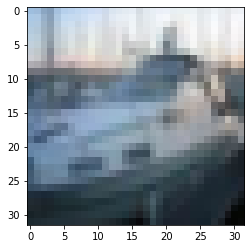

In [8]:
import matplotlib.pyplot as plt

for test_images, _ in testloader:
    sample_image = test_images[2]
    break;
plt.imshow(sample_image.permute(1,2,0))

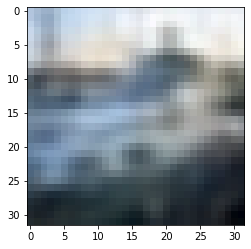

In [9]:
with torch.no_grad():
    prediction = model(sample_image.unsqueeze(0).to(device))
    plt.imshow(prediction.cpu().reshape(3,32,32).permute(1,2,0))